# Deep Hedging AI
### Convergence to Black & Scholes Delta
#### Base case: BS with (statistical) drift 0.1, cvar@1, 400 epochs, zero cost
#### This file: no drift, exp2@10 utility
Hans Buehler, January 2nd, 2023


Deep Hedging AI says hello  ... Tensorflow version 2.7.0


## Deep Hedging in a Black \& Scholes World

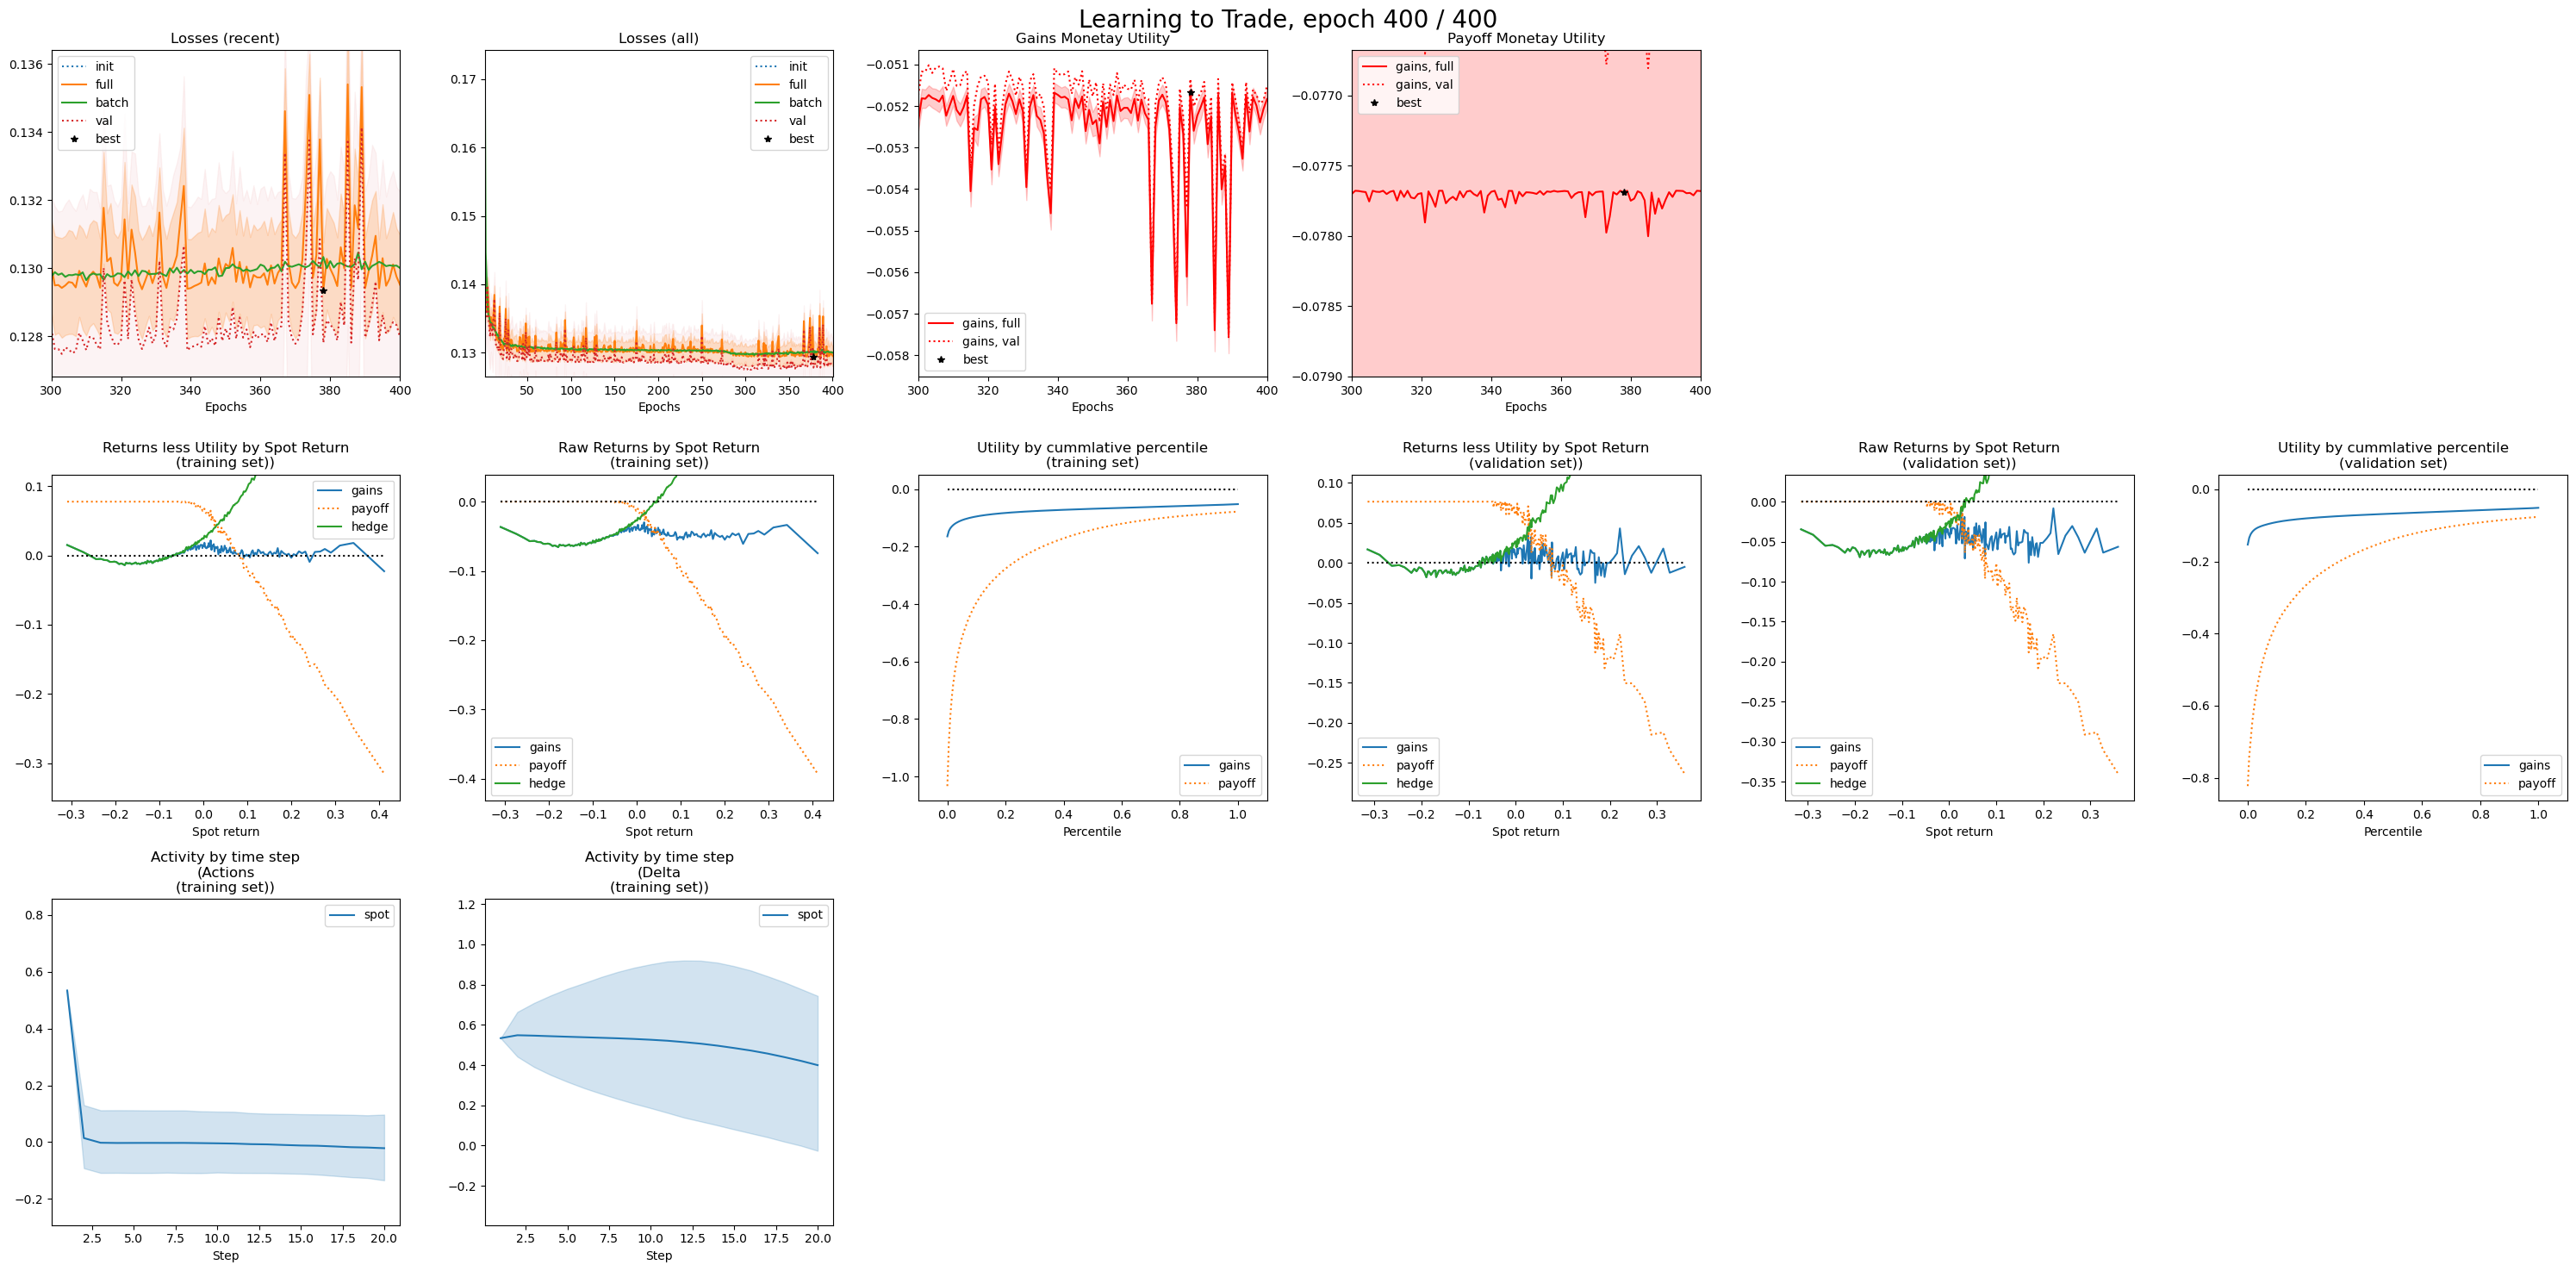

Training 400/400 epochs; 10000 samples; 1000 validation samples batch size 32 | initial loss 4.09374 (0.0975195), full 0.129513 (0.00146995), best 0.129349 (0.0975195), batch 0.130004, val 0.127968 (0.00427626). Best epoch 377 | time elapsed 1:31:27; time per epoch 13s; estimated time remaining 13s                           
 Status: Ran all 400 epochs.
 Weights set to best epoch: 377

Keys of the dictionary returned by the gym:  odict_keys(['loss', 'utility', 'utility0', 'gains', 'payoff', 'pnl', 'cost', 'actions', 'deltas'])
Config usage report
config.gym.agent.network['activation'] = softplus # Network activation function; default: relu
config.gym.agent.network['depth'] = 5 # Network depth; default: 3
config.gym.agent.network['final_activation'] = linear # Network activation function for the last layer; default: linear
config.gym.agent.network['width'] = 40 # Network width; default: 20
config.gym.agent.network['zero_model'] = False # Create a model with zero initial value, but rando

In [1]:
"""
When working on the code base, activate below code:

import imp
import deephedging.base as base
imp.reload(base)
import deephedging.world as world
imp.reload(world)
import deephedging.agents as agents
imp.reload(agents)
import deephedging.objectives as objectives
imp.reload(objectives)
import deephedging.gym as gym
imp.reload(gym)
import deephedging.trainer as trainer
imp.reload(trainer)
"""

# no drift + new utility

print("Deep Hedging AI says hello  ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world
config.world.samples = 10000
config.world.steps = 20
config.world.black_scholes = True
config.world.rvol = 0.2    # 20% volatility
config.world.drift = 0.    # zero drift
config.world.cost_s = 0.0002
#config.world.dt = 1./50.
# gym
config.gym.objective.utility = "exp2"
config.gym.objective.lmbda = 10.  
config.gym.agent.network.depth = 5
config.gym.agent.network.width = 40
config.gym.agent.network.activation = "softplus"
#config.gym.agent.features = []#'spot', 'time_left', 'sqrt_time_left' ]
# trainer
#config.trainer.train.optimizer = "adam"
config.trainer.train.batch_size = None
config.trainer.train.epochs = 400
config.trainer.visual.epoch_refresh = 1
config.trainer.visual.time_refresh = 10
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75

display(Markdown("## Deep Hedging in a Black \& Scholes World"))

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=1000)

# create training environment
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
r = gym(world.tf_data)
print("Keys of the dictionary returned by the gym: ", r.keys())

print("=========================================")
print("Config usage report")
print("=========================================")
print( config.usage_report() )
config.done()


## Hedging results in detail (full data set)

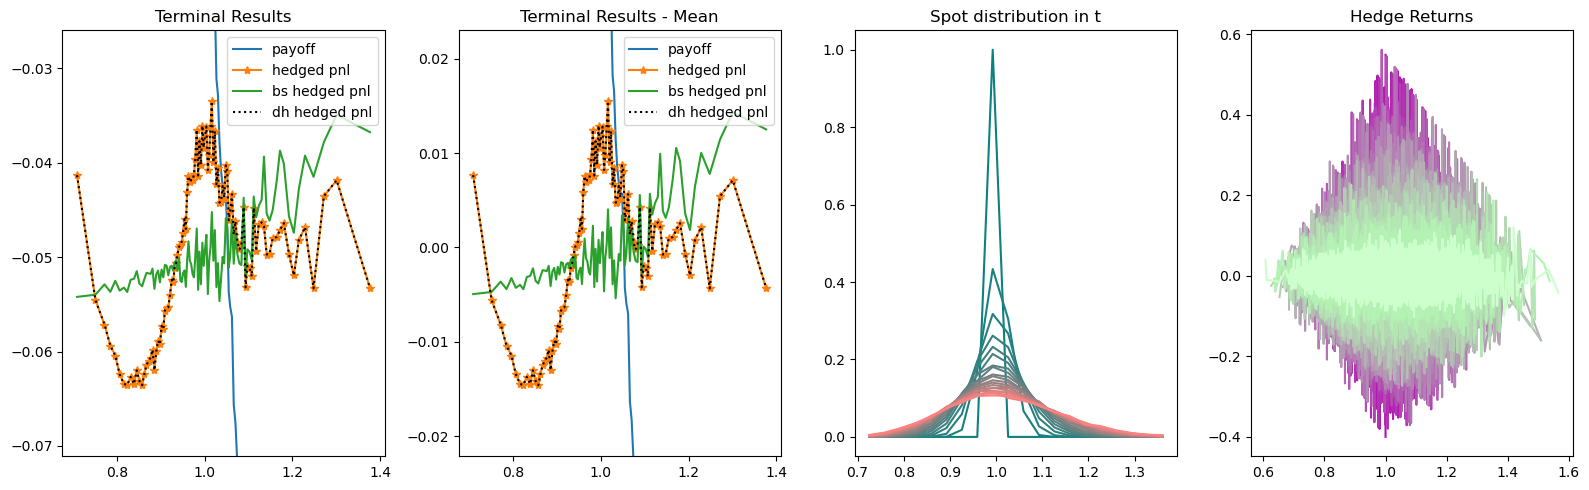

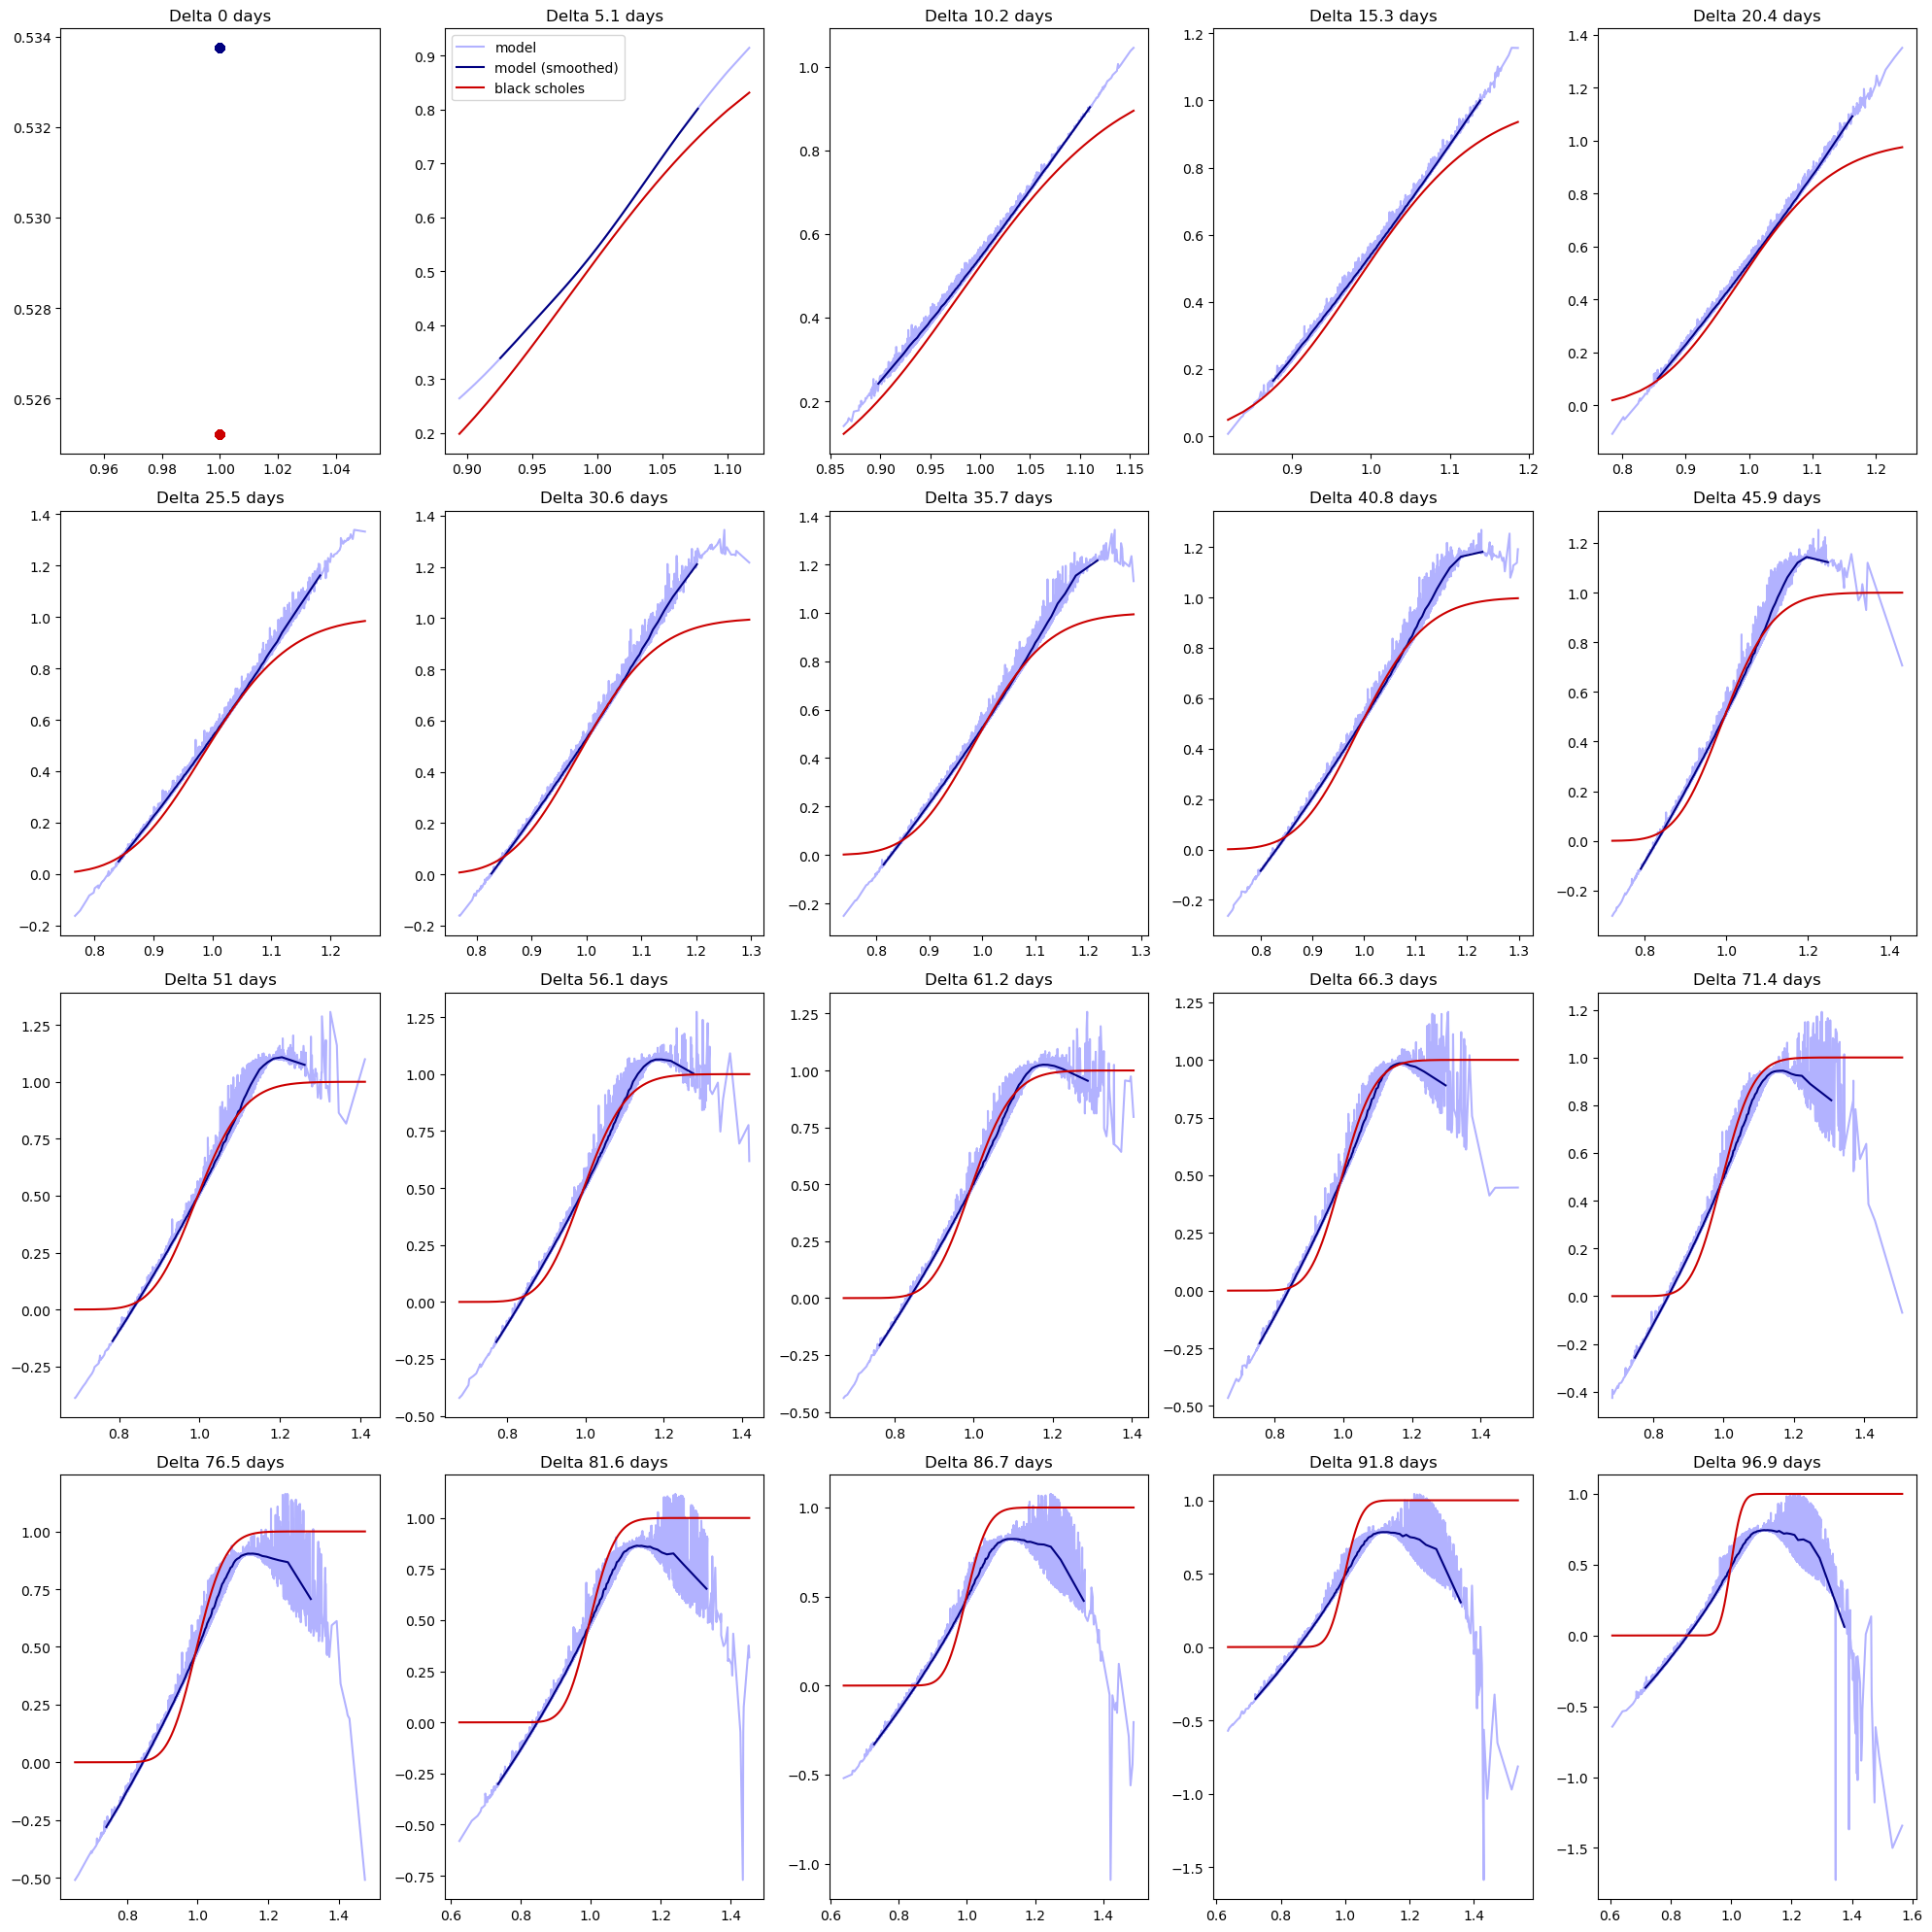

In [2]:
import deephedging.plot_bs_hedge as plot_bs_hedge
import imp
imp.reload(plot_bs_hedge)

display(Markdown("## Hedging results in detail (full data set)"))
plot_bs_hedge.plot_blackscholes( world, gym, config )
